In [156]:
from torch.utils.checkpoint import checkpoint
!pip install torch torchvision torchaudio matplotlib numpy tqdm

In [157]:
# base
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm

# helpers
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.transforms import v2

In [158]:
plt.style.use('Solarize_Light2')

In [159]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

Device: cpu


In [160]:
class DatasetReg (Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform
        
        self.list_name_file = os.listdir(path)
        if 'coords.json' in self.list_name_file:
            self.list_name_file.remove('coords.json')
        
        self.len_dataset = len(self.list_name_file)
        
        with open(os.path.join(self.path, 'coords.json'), 'r') as f:
            self.dict_coords = json.load(f)

    def __getitem__(self, index):
        name_file = self.list_name_file[index]
        path_img = os.path.join(self.path, name_file)
        
        img = Image.open(path_img)
        coord = torch.tensor(self.dict_coords[name_file], dtype=torch.float32)
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img, coord

    def __len__(self):
        return self.len_dataset

In [163]:
transform = v2.Compose([
    v2.ToImage(),
    # v2.ToDtype(torch.float32, scale=True),
    # v2.Normalize(mean=(0.5, ), std=(0.5, ))
])

dataset = DatasetReg('./dataset', transform=transform)

dataset[2000]

(Image([[[29,  0,  8,  ..., 42, 31, 32],
         [56, 40, 21,  ..., 34,  0, 32],
         [34, 12, 23,  ...,  0, 18,  1],
         ...,
         [43, 17, 38,  ...,  5, 46, 11],
         [27, 31, 25,  ...,  8, 49, 35],
         [ 4, 13, 22,  ..., 32, 31, 13]]], dtype=torch.uint8, ),
 tensor([24., 26.]))

In [119]:
train_set, val_set, test_set = random_split(dataset, [0.7, 0.1, 0.2])

In [120]:
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

In [121]:
class MyModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.layer_1 = nn.Linear(input_size, 128)
        self.layer_2 = nn.Linear(128, output_size)
        self.act = nn.ReLU()
    
    def forward(self, x):
        x = self.layer_1(x)
        x = self.act(x)
        out = self.layer_2(x)
        
        return out
    
model = MyModel(input_size=64*64, output_size=2).to(device)


In [122]:
loss_model = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 
                                                          mode='min',
                                                          factor=0.1,
                                                          patience=5)

In [155]:
EPOCHS = 30
train_loss = []
train_acc = []
val_loss = []
val_acc = []
lr_list = []

# save/load model
best_loss_epoch = None
best_loss = None

In [124]:
# input = torch.rand([16, 64*64], dtype=torch.float32).to(device)
# 
# out = model(input)
# out.shape

In [125]:
for epoch in range(EPOCHS):

    # INFO model training
    model.train()
    train_loop = tqdm(train_loader, leave=False)
    
    running_train_loss = []
    true_answer_counter = 0
    for x, targets in train_loop:        
        x = x.reshape(-1, 64*64).to(device)
        targets = targets.to(device) 
        
        prediction = model(x) # forward method
        loss = loss_model(prediction, targets) # loss func
        
        # back prapagetion start
        opt.zero_grad() # reset previously calculated gradients
        loss.backward()
        # back prapagetion end
        
        # optimization step
        opt.step()
        
        # INFO training process visualization
        running_train_loss.append(loss.item())
        mean_train_loss = sum(running_train_loss)/len(running_train_loss)
        
        true_answer_counter += (torch.round(prediction) == targets).all(dim=1).sum().item()
        
        train_loop.set_description(f'Epoch [{epoch+1}/{EPOCHS}], train_loss_avg: {mean_train_loss:.4f}')

    running_train_acc = true_answer_counter/len(train_set)
    
    train_loss.append(mean_train_loss)
    train_acc.append(running_train_acc)
    
    # INFO model validation
    model.eval()
    with torch.no_grad():
        running_val_loss = []
        true_answer_counter = 0
        for x, targets in val_loader:
            x = x.reshape(-1, 64*64).to(device)
            targets = targets.to(device) 
            
            prediction = model(x)
            loss = loss_model(prediction, targets)
            
            # INFO training process visualization
            running_val_loss.append(loss.item())
            mean_val_loss = sum(running_val_loss)/len(running_val_loss)
            
            true_answer_counter += (torch.round(prediction) == targets).all(dim=1).sum().item()
    
        running_val_acc = true_answer_counter / len(val_set)
        
        val_loss.append(mean_val_loss)
        val_acc.append(running_val_acc)
    
    lr_scheduler.step(mean_val_loss)
    lr = lr_scheduler._last_lr[0]
    lr_list.append(lr)
        
    print(f'Epoch [{epoch+1}/{EPOCHS}], train_loss: {mean_train_loss:.4f}, train_metric_acc: {running_train_acc:.4f}, val_loss: {mean_val_loss:.4f}, val_metric_acc: {running_val_acc:.4f}, lr: {lr:.4f}')
    
    if best_loss is None:
        best_loss = mean_train_loss
        best_loss_epoch = epoch
    if mean_train_loss < best_loss: # better best_loss - mean_val_loss > threshold | mean_val_loss < best_loss - best_loss * threshold
        
        path = f'serialized/regression/regression_model_state_dict_epoch_{best_loss_epoch+1}.pt'
        if os.path.exists(path):    
            os.remove(path)
        
        best_loss = mean_train_loss
        best_loss_epoch = epoch
        torch.save(model.state_dict(), f'serialized/regression/regression_model_state_dict_epoch_{epoch+1}.pt')
        
        print(f'Epoch - {epoch+1}, model has been saved with loss on validation set - {mean_train_loss:.4f}', end='\n\n')

Epoch [1/15], train_loss: 1.6616, train_metric_acc: 0.6538, val_loss: 0.1202, val_metric_acc: 0.7188, lr: 0.0010


Epoch [2/15], train_loss: 0.1335, train_metric_acc: 0.6941, val_loss: 0.1613, val_metric_acc: 0.6086, lr: 0.0010
Epoch - 2, model has been saved with loss on validation set - 0.1335



Epoch [3/15], train_loss: 0.1145, train_metric_acc: 0.7485, val_loss: 0.0970, val_metric_acc: 0.8012, lr: 0.0010
Epoch - 3, model has been saved with loss on validation set - 0.1145



Epoch [4/15], train_loss: 0.0982, train_metric_acc: 0.7990, val_loss: 0.0759, val_metric_acc: 0.8663, lr: 0.0010
Epoch - 4, model has been saved with loss on validation set - 0.0982



Epoch [5/15], train_loss: 0.0866, train_metric_acc: 0.8363, val_loss: 0.0581, val_metric_acc: 0.9296, lr: 0.0010
Epoch - 5, model has been saved with loss on validation set - 0.0866



Epoch [6/15], train_loss: 0.0808, train_metric_acc: 0.8540, val_loss: 0.0538, val_metric_acc: 0.9414, lr: 0.0010
Epoch - 6, model has been saved with loss on validation set - 0.0808



Epoch [7/15], train_loss: 0.0741, train_metric_acc: 0.8755, val_loss: 0.0571, val_metric_acc: 0.9283, lr: 0.0010
Epoch - 7, model has been saved with loss on validation set - 0.0741



Epoch [8/15], train_loss: 0.0707, train_metric_acc: 0.8869, val_loss: 0.0519, val_metric_acc: 0.9428, lr: 0.0010
Epoch - 8, model has been saved with loss on validation set - 0.0707



Epoch [9/15], train_loss: 0.0671, train_metric_acc: 0.8982, val_loss: 0.0515, val_metric_acc: 0.9431, lr: 0.0010
Epoch - 9, model has been saved with loss on validation set - 0.0671



Epoch [10/15], train_loss: 0.0645, train_metric_acc: 0.9054, val_loss: 0.0457, val_metric_acc: 0.9608, lr: 0.0010
Epoch - 10, model has been saved with loss on validation set - 0.0645



Epoch [11/15], train_loss: 0.0596, train_metric_acc: 0.9200, val_loss: 0.0954, val_metric_acc: 0.8298, lr: 0.0010
Epoch - 11, model has been saved with loss on validation set - 0.0596



Epoch [12/15], train_loss: 0.0582, train_metric_acc: 0.9239, val_loss: 0.0515, val_metric_acc: 0.9405, lr: 0.0010
Epoch - 12, model has been saved with loss on validation set - 0.0582



Epoch [13/15], train_loss: 0.0564, train_metric_acc: 0.9300, val_loss: 0.0591, val_metric_acc: 0.9258, lr: 0.0010
Epoch - 13, model has been saved with loss on validation set - 0.0564



Epoch [14/15], train_loss: 0.0550, train_metric_acc: 0.9340, val_loss: 0.0486, val_metric_acc: 0.9402, lr: 0.0010
Epoch - 14, model has been saved with loss on validation set - 0.0550



Epoch [15/15], train_loss: 0.0531, train_metric_acc: 0.9388, val_loss: 0.0435, val_metric_acc: 0.9662, lr: 0.0010
Epoch - 15, model has been saved with loss on validation set - 0.0531



In [131]:
# INFO Adam = lr=0.001 speed | EPOCHS = 50
# INFO Epoch 49/50: train_loss: 0.0392, train_metric_acc: 0.9736, val_loss: 0.0420, val_metric_acc: 0.9675
# INFO Epoch 50/50: train_loss: 0.0391, train_metric_acc: 0.9724, val_loss: 0.0505, val_metric_acc: 0.9361

# INFO Adam = lr=0.0001 speed | EPOCHS = 10
# INFO Epoch 9/10: train_loss: 0.0241, train_metric_acc: 0.9965, val_loss: 0.0352, val_metric_acc: 0.9793
# INFO Epoch 10/10: train_loss: 0.0241, train_metric_acc: 0.9967, val_loss: 0.0308, val_metric_acc: 0.9874

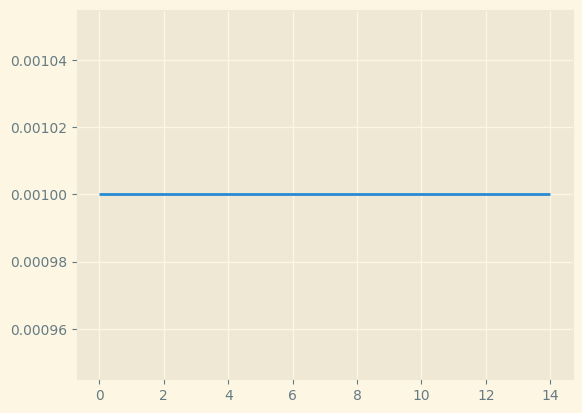

In [132]:
plt.plot(lr_list)
plt.show()

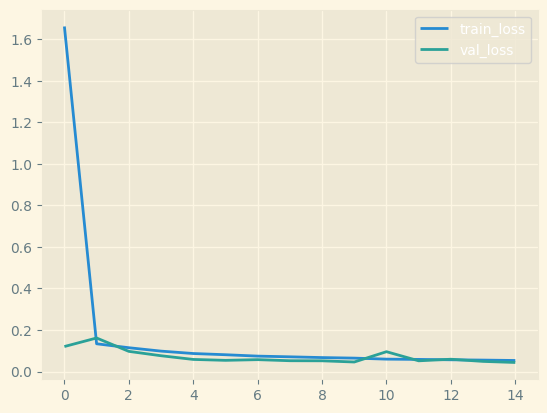

In [133]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['train_loss', 'val_loss'])
plt.show()

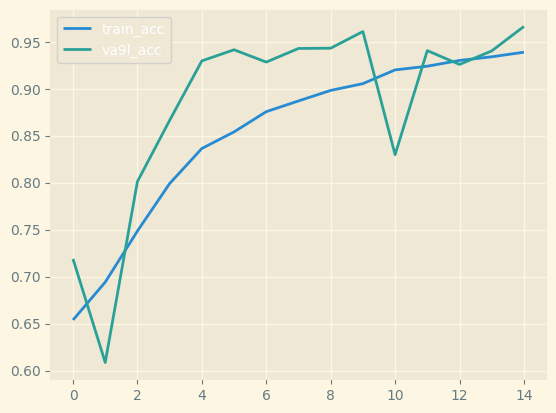

In [134]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['train_acc', 'va9l_acc'])
plt.show()

In [145]:
str_info = '''
class MyModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.layer_1 = nn.Linear(input_size, 128)
        self.layer_2 = nn.Linear(128, output_size)
        self.act = nn.ReLU()
    
    def forward(self, x):
        x = self.layer_1(x)
        x = self.act(   x)
        out = self.layer_2(x)
        
        return out
        
MyModel(input_size=64*64, output_size=2)
'''

checkpoint = {
    'info': str_info,
    'state_model': model.state_dict(),
    'state_opt': opt.state_dict(),
    'state_lr_scheduler': lr_scheduler.state_dict(),
    'loss': {
        'train_loss': train_loss,
        'val_loss': val_loss,
        'best_loss': best_loss,
    },
    'metric': {
        'train_acc': train_acc,
        'val_acc': val_acc,
    },
    'lr': lr_list,
    'epoch': {
        'EPOCHS': EPOCHS,
        'save_epoch': best_loss_epoch,
    },
}

torch.save(checkpoint, 'serialized/regression/regression_state_dict_model.pt')

In [146]:
load_model_state = torch.load('serialized/regression/regression_state_dict_model.pt')
load_model_state['info']

/var/folders/wz/07ctdm5s7rd0j4q2q_5qys5m0000gn/T/ipykernel_33896/3324214028.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_model_state = torch.load('serialized/reg

'\nclass MyModel(nn.Module):\n    def __init__(self, input_size, output_size):\n        super().__init__()\n        self.layer_1 = nn.Linear(input_size, 128)\n        self.layer_2 = nn.Linear(128, output_size)\n        self.act = nn.ReLU()\n    \n    def forward(self, x):\n        x = self.layer_1(x)\n        x = self.act(x)\n        out = self.layer_2(x)\n        \n        return out\n        \nMyModel(input_size=64*64, output_size=2)\n'

In [147]:
# params_model = torch.load(f'serialized/regression/regression_model_state_dict_epoch_{best_loss_epoch+1}.pt')
# params_model

In [148]:
new_model = MyModel(64*64, 2).to(device)

loss_model = nn.MSELoss()
new_opt = torch.optim.Adam(new_model.parameters(), lr=0.001)
new_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(new_opt)

In [149]:
new_model.load_state_dict(load_model_state['state_model'])
new_opt.load_state_dict(load_model_state['state_opt'])
new_scheduler.load_state_dict(load_model_state['state_lr_scheduler'])

In [150]:
# new_model.eval()
# with torch.no_grad():
#     running_val_loss = []
#     true_answer_counter = 0
#     
#     for x, targets in val_loader:
#         x = x.reshape(-1, 64*64).to(device)
#         targets = targets.to(device)
#         
#         prediction = new_model(x)
#         loss = loss_model(prediction, targets)
#         
#         running_val_loss.append(loss.item())
#         mean_val_loss = sum(running_val_loss)/len(running_val_loss)
#         
#         true_answer_counter += (torch.round(prediction) == targets).all(dim=1).sum().item()
#         
#     running_val_acc = true_answer_counter / len(val_set)
#     
# print(f'val_loss: {mean_val_loss:.4f}, val_metric_acc: {running_val_acc:.4f}')

In [154]:
EPOCHS = load_model_state['epoch']['EPOCHS']
save_epoch = load_model_state['epoch']['save_epoch']

train_loss = load_model_state['loss']['train_loss']
train_metric_acc = load_model_state['metric']['train_acc']
val_loss = load_model_state['loss']['val_loss']
val_metric_acc = load_model_state['metric']['val_acc']
lr_list = load_model_state['lr']

best_loss = load_model_state['loss']['best_loss']

for epoch in range(save_epoch + 1, EPOCHS):

    # INFO model training
    new_model.train()
    train_loop = tqdm(train_loader, leave=False)
    
    running_train_loss = []
    true_answer_counter = 0
    for x, targets in train_loop:        
        x = x.reshape(-1, 64*64).to(device)
        targets = targets.to(device) 
        
        prediction = new_model(x) # forward method
        loss = loss_model(prediction, targets) # loss func
        
        # back prapagetion start
        new_opt.zero_grad() # reset previously calculated gradients
        loss.backward()
        # back prapagetion end
        
        # optimization step
        new_opt.step()
        
        # INFO training process visualization
        running_train_loss.append(loss.item())
        mean_train_loss = sum(running_train_loss)/len(running_train_loss)
        
        true_answer_counter += (torch.round(prediction) == targets).all(dim=1).sum().item()
        
        train_loop.set_description(f'Epoch [{epoch+1}/{EPOCHS}], train_loss_avg: {mean_train_loss:.4f}')

    running_train_acc = true_answer_counter/len(train_set)
    
    train_loss.append(mean_train_loss)
    train_acc.append(running_train_acc)
    
    # INFO model validation
    new_model.eval()
    with torch.no_grad():
        running_val_loss = []
        true_answer_counter = 0
        for x, targets in val_loader:
            x = x.reshape(-1, 64*64).to(device)
            targets = targets.to(device) 
            
            prediction = new_model(x)
            loss = loss_model(prediction, targets)
            
            # INFO training process visualization
            running_val_loss.append(loss.item())
            mean_val_loss = sum(running_val_loss)/len(running_val_loss)
            
            true_answer_counter += (torch.round(prediction) == targets).all(dim=1).sum().item()
    
        running_val_acc = true_answer_counter / len(val_set)
        
        val_loss.append(mean_val_loss)
        val_acc.append(running_val_acc)
    
    new_scheduler.step(mean_val_loss)
    lr = new_scheduler._last_lr[0]
    lr_list.append(lr)
        
    print(f'Epoch [{epoch+1}/{EPOCHS}], train_loss: {mean_train_loss:.4f}, train_metric_acc: {running_train_acc:.4f}, val_loss: {mean_val_loss:.4f}, val_metric_acc: {running_val_acc:.4f}, lr: {lr:.4f}')
    
    if best_loss is None:
        best_loss = mean_train_loss
        best_loss_epoch = epoch
    if mean_train_loss < best_loss: # better best_loss - mean_val_loss > threshold | mean_val_loss < best_loss - best_loss * threshold
        best_loss = mean_train_loss
        
        checkpoint = {
            'info': str_info,
            'state_model': new_model.state_dict(),
            'state_opt': new_opt.state_dict(),
            'state_lr_scheduler': new_scheduler.state_dict(),
            'loss': {
                'train_loss': train_loss,
                'val_loss': val_loss,
                'best_loss': best_loss,
            },
            'metric': {
                'train_acc': train_acc,
                'val_acc': val_acc,
            },
            'lr': lr_list,
            'epoch': {
                'EPOCHS': EPOCHS,
                'save_epoch': best_loss_epoch,
            },
        }
        
        torch.save(checkpoint, f'serialized/regression/regression_model_state_dict_epoch_{epoch+1}.pt')
        
        print(f'Epoch - {epoch+1}, model has been saved with loss on validation set - {mean_train_loss:.4f}', end='\n\n')

Epoch [16/25], train_loss: 0.0523, train_metric_acc: 0.9407, val_loss: 0.1132, val_metric_acc: 0.7564, lr: 0.0010
Epoch - 16, model has been saved with loss on validation set - 0.0523



Epoch [17/25], train_loss: 0.0503, train_metric_acc: 0.9469, val_loss: 0.0434, val_metric_acc: 0.9630, lr: 0.0010
Epoch - 17, model has been saved with loss on validation set - 0.0503



Epoch [18/25], train_loss: 0.0510, train_metric_acc: 0.9454, val_loss: 0.0480, val_metric_acc: 0.9593, lr: 0.0010


Epoch [19/25], train_loss: 0.0514, train_metric_acc: 0.9442, val_loss: 0.0424, val_metric_acc: 0.9623, lr: 0.0010


Epoch [20/25], train_loss: 0.0495, train_metric_acc: 0.9492, val_loss: 0.0407, val_metric_acc: 0.9738, lr: 0.0010
Epoch - 20, model has been saved with loss on validation set - 0.0495



Epoch [21/25], train_loss: 0.0495, train_metric_acc: 0.9481, val_loss: 0.0386, val_metric_acc: 0.9730, lr: 0.0010


Epoch [22/25], train_loss: 0.0489, train_metric_acc: 0.9493, val_loss: 0.1425, val_metric_acc: 0.6962, lr: 0.0010
Epoch - 22, model has been saved with loss on validation set - 0.0489



Epoch [23/25], train_loss: 0.0484, train_metric_acc: 0.9519, val_loss: 0.0405, val_metric_acc: 0.9704, lr: 0.0010
Epoch - 23, model has been saved with loss on validation set - 0.0484



Epoch [24/25], train_loss: 0.0483, train_metric_acc: 0.9514, val_loss: 0.0464, val_metric_acc: 0.9597, lr: 0.0010
Epoch - 24, model has been saved with loss on validation set - 0.0483



Epoch [25/25], train_loss: 0.0476, train_metric_acc: 0.9539, val_loss: 0.0558, val_metric_acc: 0.9408, lr: 0.0010
Epoch - 25, model has been saved with loss on validation set - 0.0476

